In [102]:
import numpy as np
import cv2
import tensorflow as tf

def concat_images_resize_128(images, labels, n_mix=2):
    batch_size, h, w, c = images.shape
    final_h, final_w = 128, 128
    width_per_img = final_w // n_mix

    mixed_images = []
    mixed_labels = []

    for _ in range(batch_size):
        idxs = np.random.choice(batch_size, n_mix, replace=True)
        imgs_to_concat = []

        for i in idxs:
            # Redimensionner chaque image à (128, width_per_img)
            resized_img = cv2.resize(images[i], (width_per_img, final_h))
            imgs_to_concat.append(resized_img)

        # Concaténation horizontale des n_mix images
        concat_img = np.hstack(imgs_to_concat)

        # Moyenne des labels pour avoir un label multi-label
        mixed_label = np.max(labels[idxs], axis=0)

        mixed_images.append(concat_img)
        mixed_labels.append(mixed_label)

    return np.array(mixed_images), np.array(mixed_labels)

class MixConcatResizeGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, n_mix=2):
        self.generator = generator
        self.n_mix = n_mix

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        images, labels = self.generator[idx]
        mixed_images, mixed_labels = concat_images_resize_128(images, labels, self.n_mix)
        return mixed_images, mixed_labels


In [103]:
#Lecture Data

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paramètres
img_size = (128, 128)
batch_size = 32

# Générateurs
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "data/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    "data/validation",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    "data/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Remplace train_gen par ce générateur mixup
train_gen_mixup = MixConcatResizeGenerator(train_gen, n_mix=2)
test_gen_mixup = MixConcatResizeGenerator(test_gen, n_mix=2)
val_gen_mixup = MixConcatResizeGenerator(val_gen, n_mix=2)
print(len(train_gen_mixup) * train_gen.batch_size)

Found 4897 images belonging to 36 classes.
Found 635 images belonging to 36 classes.
Found 557 images belonging to 36 classes.
4928


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Récupérer un batch du générateur mixup
images, labels = train_gen_mixup[0]  # premier batch (index 0)

# Nombre d’images à afficher (max 9)
n = min(9, images.shape[0])

# Assure-toi que tu as la liste des noms de classes dans l’ordre correct
class_names = ['onion' 'orange' 'tomato' 'apple' 'turnip' 'sweetpotato' 'lettuce'
 'grapes' 'banana' 'paprika' 'ginger' 'chilli pepper' 'lemon' 'potato'
 'cabbage' 'pomegranate' 'soy beans' 'cucumber' 'jalepeno' 'capsicum'
 'watermelon' 'kiwi' 'pineapple' 'cauliflower' 'bell pepper' 'pear'
 'raddish' 'carrot' 'eggplant' 'mango' 'beetroot' 'peas' 'spinach'
 'sweetcorn' 'corn' 'garlic']  # adapte ici

fig, axes = plt.subplots(3, 3, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

axes = axes.flatten()

for i in range(n):
    ax = axes[i]
    img = images[i]
    
    # img est en float (0-1 ?), si besoin convertir en uint8 0-255 pour afficher correctement
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    
    ax.imshow(img)
    
    # Labels binaires, on affiche les noms où label = 1 (ou > 0.5)
    label_vec = labels[i]
    active_labels = [class_names[j] for j, val in enumerate(label_vec) if val > 0.5]
    
    ax.set_title(', '.join(active_labels), fontsize=9)

plt.tight_layout()
plt.show()


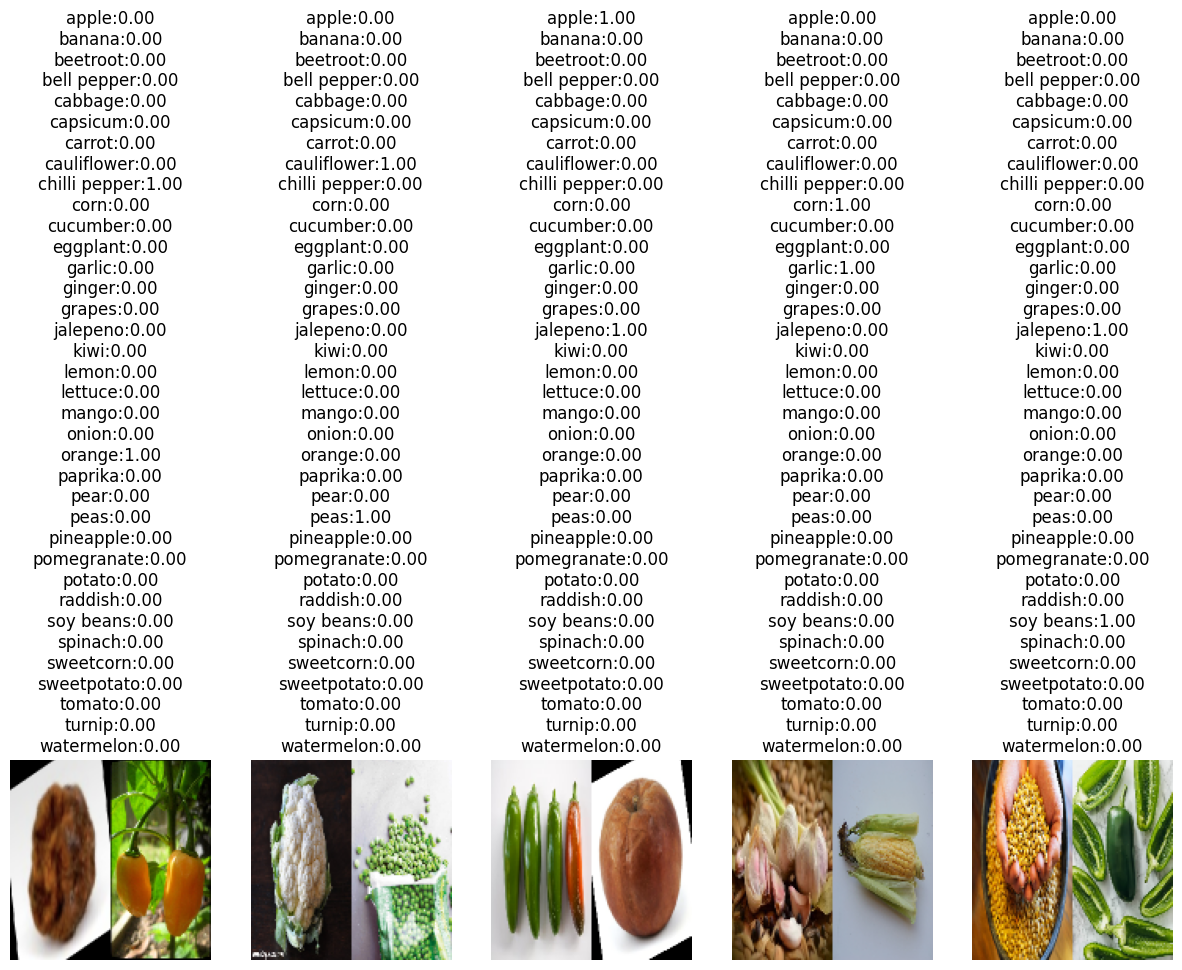

In [104]:
import matplotlib.pyplot as plt

def show_first_images(generator, class_indices):
    images, labels = generator[0]  # Prend le premier batch
    label_names = list(class_indices.keys())
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        # Affiche les pourcentages pour chaque classe
        label_percent = [f"{name}:{labels[i][j]:.2f}" for j, name in enumerate(label_names)]
        plt.title("\n".join(label_percent))
        plt.axis('off')
    plt.show()

# Utilisation :
show_first_images(train_gen_mixup, train_gen.class_indices)

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Multilabel output layer
    Dense(train_gen.num_classes, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(
    monitor='val_loss',      # Surveille la perte de validation
    patience=3,              # Arrête après 3 epochs sans amélioration
    restore_best_weights=True
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,526,180 (24.90 MB)

 Trainable params: 6,525,732 (24.89 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(
    train_gen_mixup,
    validation_data=val_gen_mixup,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 104s 660ms/step - accuracy: 0.1956 - loss: 0.5445 - val_accuracy: 0.0882 - val_loss: 0.2221
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 100s 649ms/step - accuracy: 0.2751 - loss: 0.2511 - val_accuracy: 0.2441 - val_loss: 0.2006
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 667ms/step - accuracy: 0.3288 - loss: 0.2321 - val_accuracy: 0.3213 - val_loss: 0.1709
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 143s 929ms/step - accuracy: 0.3463 - loss: 0.2165 - val_accuracy: 0.3717 - val_loss: 0.1596
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 147s 955ms/step - accuracy: 0.3413 - loss: 0.2046 - val_accuracy: 0.3150 - val_loss: 0.1778
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.3691 - loss: 0.1972 - val_accuracy: 0.4236 - val_loss: 0.1524
Epoch 7/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.3752 - loss: 0.1927

In [ ]:
# Évaluation
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.2%}")

# Prédiction sur de nouvelles images
import numpy as np
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Correspondance index-classe
labels = train_gen.class_indices
labels = dict((v,k) for k,v in labels.items())

# Exemple
for i in range(5):
    print(f"Predicted: {labels[predicted_classes[i]]}, True: {labels[test_gen.classes[i]]}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.4544 - loss: 0.0939
Test Accuracy: 29.98%
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 489ms/step
Predicted: onion, True: apple
Predicted: onion, True: apple
Predicted: banana, True: apple
Predicted: paprika, True: apple
Predicted: orange, True: apple
